<a href="https://colab.research.google.com/github/VishalPrem1994/AIGenPlayGround/blob/main/TFAutoModelForTokenClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers datasets torch tochvision
!pip install accelerate -U

ERROR: Could not find a version that satisfies the requirement tochvision (from versions: none)
ERROR: No matching distribution found for tochvision


In [ ]:
from transformers import AutoProcessor, TFAutoModelForTokenClassification, Trainer
import accelerate
import transformers
from datasets import load_dataset
import torch

### Inference

In [ ]:


processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)
model = TFAutoModelForTokenClassification.from_pretrained("microsoft/layoutlmv3-base", num_labels=7)

dataset = load_dataset("nielsr/funsd-layoutlmv3", split="test")
example = dataset[0]
image = example["image"]
words = example["tokens"]
boxes = example["bboxes"]
word_labels = example["ner_tags"]

encoding = processor(image, words, boxes=boxes, word_labels=word_labels, return_tensors="tf")

outputs = model(**encoding)
# loss = outputs.loss
# logits = outputs.logits

All model checkpoint layers were used when initializing TFLayoutLMv3ForTokenClassification.

Some layers of TFLayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['dropout', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
print(model.num_labels)

7


In [ ]:
outputs.logits.numpy()

array([[[ 0.50071174,  0.01239661,  0.43814945, ..., -0.61552405,
         -0.1330928 ,  0.39383796],
        [ 0.10474317,  0.00301229, -0.07573045, ..., -0.40868038,
         -0.15381873, -0.29832837],
        [ 0.21187952,  0.01025306,  0.24905418, ..., -0.603045  ,
         -0.31270793,  0.08801183],
        ...,
        [-0.16728249,  0.04141575,  0.19596562, ..., -0.46404114,
          0.05456414,  0.19827469],
        [ 0.1220977 , -0.16585322, -0.42728674, ..., -0.40467927,
          0.16650699,  0.7635721 ],
        [ 0.50325793,  0.01232533,  0.43766943, ..., -0.6147721 ,
         -0.13373575,  0.39446604]]], dtype=float32)

In [ ]:
torch.softmax(torch.tensor(outputs.logits.numpy()),dim=-1)

tensor([[[0.1947, 0.1195, 0.1829,  ..., 0.0638, 0.1033, 0.1750],
         [0.1705, 0.1540, 0.1423,  ..., 0.1020, 0.1316, 0.1139],
         [0.1750, 0.1431, 0.1817,  ..., 0.0775, 0.1036, 0.1546],
         ...,
         [0.1170, 0.1441, 0.1682,  ..., 0.0870, 0.1460, 0.1686],
         [0.1416, 0.1062, 0.0818,  ..., 0.0836, 0.1481, 0.2690],
         [0.1949, 0.1193, 0.1826,  ..., 0.0637, 0.1031, 0.1748]]])

### training

In [16]:
!pip install transformers datasets seqeval
!pip install transformers -U
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=8496fca92fdffaff3a5bdc9e2007275cb98881482fdb2c366cde0cc00e2aa093
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [2]:
from transformers import AutoProcessor, TFAutoModelForTokenClassification, Trainer, TrainingArguments
from datasets import load_dataset, Image
from PIL import Image as mg
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D
import accelerate
import transformers

In [3]:
dataset = load_dataset("nielsr/funsd-layoutlmv3")
dataset

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'bboxes', 'ner_tags', 'image'],
        num_rows: 149
    })
    test: Dataset({
        features: ['id', 'tokens', 'bboxes', 'ner_tags', 'image'],
        num_rows: 50
    })
})

In [4]:
labels = dataset['train'].features['ner_tags'].feature.names
print(labels)

['O', 'B-HEADER', 'I-HEADER', 'B-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER']


In [5]:
id2label = {v: k for v, k in enumerate(labels)}
label2id = {k: v for v, k in enumerate(labels)}
label2id

{'O': 0,
 'B-HEADER': 1,
 'I-HEADER': 2,
 'B-QUESTION': 3,
 'I-QUESTION': 4,
 'B-ANSWER': 5,
 'I-ANSWER': 6}

In [6]:
dataset["train"].features

{'id': Value(dtype='string', id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'bboxes': Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-HEADER', 'I-HEADER', 'B-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER'], id=None), length=-1, id=None),
 'image': Image(decode=True, id=None)}

In [7]:
from datasets.features import ClassLabel

features = dataset["train"].features
column_names = dataset["train"].column_names
image_column_name = "image"
text_column_name = "tokens"
boxes_column_name = "bboxes"
label_column_name = "ner_tags"

# In the event the labels are not a `Sequence[ClassLabel]`, we will need to go through the dataset to get the
# unique labels.
def get_label_list(labels):
    unique_labels = set()
    for label in labels:
        unique_labels = unique_labels | set(label)
    label_list = list(unique_labels)
    label_list.sort()
    return label_list

if isinstance(features[label_column_name].feature, ClassLabel):
    label_list = features[label_column_name].feature.names
    # No need to convert the labels since they are already ints.
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
else:
    label_list = get_label_list(dataset["train"][label_column_name])
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
num_labels = len(label_list)

In [8]:
label_list

['O',
 'B-HEADER',
 'I-HEADER',
 'B-QUESTION',
 'I-QUESTION',
 'B-ANSWER',
 'I-ANSWER']

In [9]:
features = Features({
    'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': Sequence(feature=Value(dtype='int64')),
})

In [10]:
processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)

def preprocess_data(examples):
  images = examples["image"]
  words = examples["tokens"]
  boxes = examples["bboxes"]
  word_labels = examples["ner_tags"]


  encoded_inputs = processor(images, words, boxes=boxes, word_labels=word_labels,truncation=True, padding="max_length")

  return encoded_inputs

train_dataset = dataset['train'].map(preprocess_data, batched=True, remove_columns=dataset['train'].column_names,
                                      features=features)
test_dataset = dataset['test'].map(preprocess_data, batched=True, remove_columns=dataset['test'].column_names,
                                      features=features)

Map:   0%|          | 0/149 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

In [11]:
example = train_dataset[0]
processor.tokenizer.decode(example["input_ids"])

'<s> R&D : Suggestion: Date: Licensee Yes No 597005708 R&D QUALITY IMPROVEMENT SUGGESTION/ SOLUTION FORM Name / Phone Ext. : M. Hamann P. Harper, P. Martinez 9/ 3/ 92 R&D Group: J. S. Wigand Supervisor / Manager Discontinue coal retention analyses on licensee submitted product samples (Note : Coal Retention testing is not performed by most licensees. Other B&W physical measurements as ends stability and inspection for soft spots in ciparettes are thought to be sufficient measures to assure cigarette physical integrity. The proposed action will increase laboratory productivity. ) Suggested Solutions (s) : Delete coal retention from the list of standard analyses performed on licensee submitted product samples. Special requests for coal retention testing could still be submitted on an exception basis. Have you contacted your Manager/ Supervisor? Manager Comments: Manager, please contact suggester and forward comments to the Quality Council. qip. wp</s><pad><pad><pad><pad><pad><pad><pad><p

In [ ]:
import torch

example = train_dataset[0]
for k,v in example.items():
    print(k,v.shape)

AttributeError: ignored

In [ ]:
for id, label in zip(train_dataset[0]["input_ids"], train_dataset[0]["labels"]):
  print(processor.tokenizer.decode([id]), label.item())

In [12]:
from transformers import LayoutLMv3ForTokenClassification

model = LayoutLMv3ForTokenClassification.from_pretrained("microsoft/layoutlmv3-base",
                                                         id2label=id2label,
                                                         label2id=label2id)

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
import numpy as np
from datasets import load_metric

metric = load_metric("seqeval")
return_entity_level_metrics = False

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    if return_entity_level_metrics:
        # Unpack nested dictionaries
        final_results = {}
        for key, value in results.items():
            if isinstance(value, dict):
                for n, v in value.items():
                    final_results[f"{key}_{n}"] = v
            else:
                final_results[key] = value
        return final_results
    else:
        return {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }

<ipython-input-17-b7e54a19a573>:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")


In [19]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="test",
                                  max_steps=1000,
                                  per_device_train_batch_size=2,
                                  per_device_eval_batch_size=2,
                                  learning_rate=1e-5,
                                  evaluation_strategy="steps",
                                  eval_steps=100,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="f1")

In [21]:
from transformers.data.data_collator import default_data_collator

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=processor,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,
)


In [22]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:905: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
100,No log,0.532555,0.879443,0.909588,0.894261,0.853085
200,No log,0.673719,0.891549,0.906607,0.899015,0.851302
300,No log,0.706504,0.892353,0.910084,0.901131,0.842387
400,No log,0.711187,0.899217,0.913065,0.906088,0.850945
500,0.130100,0.765031,0.902475,0.905614,0.904042,0.842862
600,0.130100,0.687160,0.913947,0.918033,0.915985,0.868418
700,0.130100,0.751058,0.910029,0.919523,0.914752,0.850707
800,0.130100,0.713240,0.908012,0.912072,0.910037,0.857958
900,0.130100,0.731874,0.908284,0.915052,0.911656,0.861999
1000,0.043200,0.744338,0.907745,0.914059,0.910891,0.861286


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:905: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


TrainOutput(global_step=1000, training_loss=0.0866362705230713, metrics={'train_runtime': 794.3607, 'train_samples_per_second': 2.518, 'train_steps_per_second': 1.259, 'total_flos': 523783817001984.0, 'train_loss': 0.0866362705230713, 'epoch': 13.33})

In [23]:
trainer.evaluate()

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:905: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'eval_loss': 0.7443376183509827,
 'eval_precision': 0.9077454366058214,
 'eval_recall': 0.9140586189766517,
 'eval_f1': 0.9108910891089109,
 'eval_accuracy': 0.8612861048377511,
 'eval_runtime': 5.1936,
 'eval_samples_per_second': 9.627,
 'eval_steps_per_second': 4.814,
 'epoch': 13.33}

In [24]:
from transformers import AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained("/content/test/checkpoint-1000")

In [25]:
example = dataset["test"][0]
print(example.keys())

dict_keys(['id', 'tokens', 'bboxes', 'ner_tags', 'image'])


In [33]:
example

{'id': '0',
 'tokens': ['TO:',
  'DATE:',
  '3',
  'Fax:',
  'NOTE:',
  '82092117',
  '614',
  '-466',
  '-5087',
  'Dec',
  '10',
  "'98",
  '17',
  ':46',
  'P.',
  '01',
  'ATT.',
  'GEN.',
  'ADMIN.',
  'OFFICE',
  'Attorney',
  'General',
  'Betty',
  'D.',
  'Montgomery',
  'CONFIDENTIAL',
  'FACSIMILE',
  'TRANSMISSION',
  'COVER',
  'SHEET',
  '(614)',
  '466-',
  '5087',
  'FAX',
  'NO.',
  'George',
  'Baroody',
  '(336)',
  '335-',
  '7392',
  'FAX',
  'NUMBER:',
  'PHONE',
  'NUMBER:',
  '(336)',
  '335-',
  '7363',
  'NUMBER',
  'OF',
  'PAGES',
  'INCLUDING',
  'COVER',
  'SHEET:',
  'June',
  'Flynn',
  'for',
  'Eric',
  'Brown/',
  '(614)',
  '466-',
  '8980',
  'SENDER',
  '/PHONE',
  'NUMBER:',
  'SPECIAL',
  'INSTRUCTIONS:',
  'IF',
  'YOU',
  'DO',
  'NOT',
  'RECEIVE',
  'ANY',
  'OF',
  'THE',
  'PAGES',
  'PROPERLY,',
  'PLEASE',
  'CONTACT',
  'SENDER',
  'AS',
  'SOON',
  'AS',
  'POSSIBLE',
  'THIS',
  'MESSAGE',
  'IS',
  'INTENDED',
  'ONLY',
  'FOR',
  'TH

In [26]:
image = example["image"]
words = example["tokens"]
boxes = example["bboxes"]
word_labels = example["ner_tags"]

encoding = processor(image, words, boxes=boxes, word_labels=word_labels, return_tensors="pt")
for k,v in encoding.items():
  print(k,v.shape)

input_ids torch.Size([1, 360])
attention_mask torch.Size([1, 360])
bbox torch.Size([1, 360, 4])
labels torch.Size([1, 360])
pixel_values torch.Size([1, 3, 224, 224])


In [29]:
import torch
with torch.no_grad():
  outputs = model(**encoding)

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:905: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


In [30]:
logits = outputs.logits
logits.shape

torch.Size([1, 360, 7])

In [31]:
predictions = logits.argmax(-1).squeeze().tolist()
print(predictions)

[6, 3, 4, 3, 4, 4, 5, 3, 3, 4, 3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 6, 6, 6, 6, 6, 6, 6, 3, 3, 4, 4, 5, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 3, 4, 4, 4, 4, 3, 4, 4, 4, 4, 5, 6, 6, 6, 6, 6, 6, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 6, 0, 6, 6, 0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 0, 0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [32]:
labels = encoding.labels.squeeze().tolist()
print(labels)

[-100, 3, -100, 3, -100, -100, 5, 3, -100, -100, 3, -100, 0, -100, -100, 5, -100, 6, -100, 6, -100, -100, 0, 0, 0, -100, 0, 0, -100, 0, -100, 0, 0, -100, 0, -100, 0, -100, -100, 0, -100, 1, 2, 2, 2, -100, 2, 1, -100, -100, -100, 2, -100, -100, 2, -100, -100, 2, 2, -100, 5, -100, -100, 6, -100, -100, 6, -100, 3, -100, 4, -100, 5, 6, -100, -100, 5, -100, -100, 6, -100, 6, -100, 3, -100, 4, -100, -100, 3, -100, 4, -100, -100, 5, -100, -100, 6, -100, 6, -100, 3, -100, 4, 4, -100, 4, -100, 4, 4, -100, -100, 5, 6, 6, 6, 6, -100, 6, -100, -100, 6, -100, -100, 6, -100, 3, -100, -100, 4, -100, -100, 4, -100, -100, 3, 4, -100, -100, -100, 1, 2, 2, 2, 2, -100, -100, 2, 2, 2, 2, -100, 2, -100, -100, -100, 2, 2, -100, 2, -100, -100, 2, 2, -100, 2, 2, -100, -100, 5, 6, -100, -100, -100, 6, 6, -100, 6, 6, 6, 6, 6, 6, 6, -100, -100, -100, 6, 6, -100, 6, 6, -100, 6, 6, 6, -100, -100, -100, 6, 6, 6, -100, 6, 6, 6, 6, -100, -100, -100, -100, -100, 6, -100, -100, -100, -100, 6, 6, -100, -100, 6, 6, -100, 

In [34]:
def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

token_boxes = encoding.bbox.squeeze().tolist()
width, height = image.size

true_predictions = [model.config.id2label[pred] for pred, label in zip(predictions, labels) if label != - 100]
true_labels = [model.config.id2label[label] for prediction, label in zip(predictions, labels) if label != -100]
true_boxes = [unnormalize_box(box, width, height) for box, label in zip(token_boxes, labels) if label != -100]

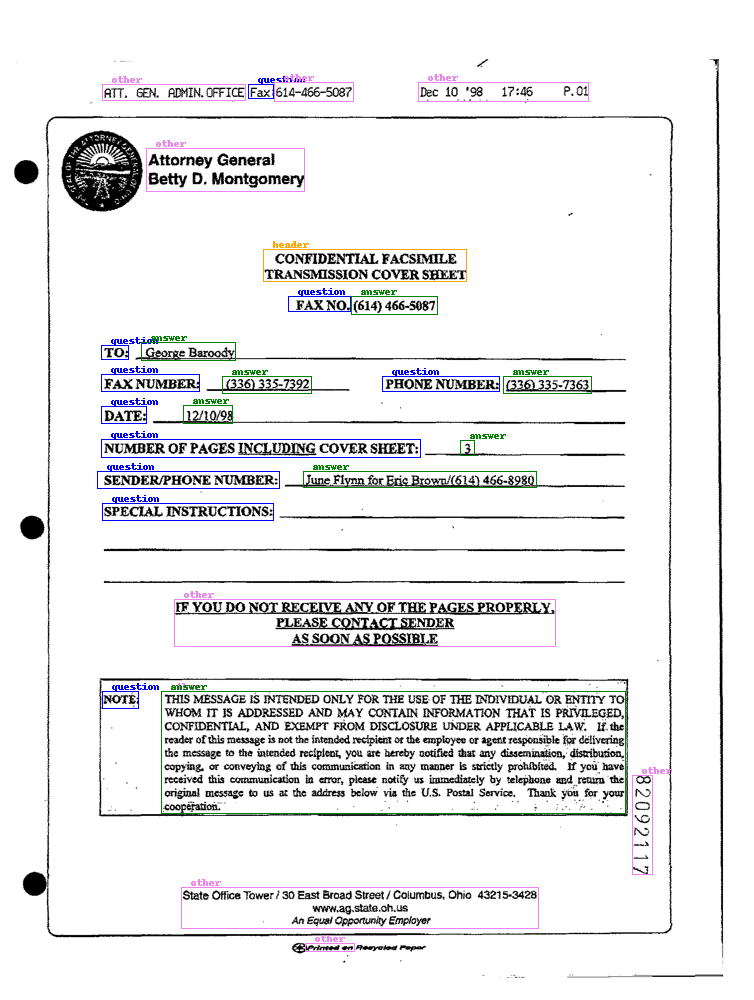

In [35]:
from PIL import ImageDraw, ImageFont

draw = ImageDraw.Draw(image)

font = ImageFont.load_default()

def iob_to_label(label):
    label = label[2:]
    if not label:
      return 'other'
    return label

label2color = {'question':'blue', 'answer':'green', 'header':'orange', 'other':'violet'}

for prediction, box in zip(true_predictions, true_boxes):
    predicted_label = iob_to_label(prediction).lower()
    draw.rectangle(box, outline=label2color[predicted_label])
    draw.text((box[0] + 10, box[1] - 10), text=predicted_label, fill=label2color[predicted_label], font=font)

image